In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, imageio, pickle, h5py

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10.0, 5.0)

# change working directory
os.chdir('/content/drive/My Drive/brainstation_capstone')

In [0]:
# use tensorflow version 2
%tensorflow_version 2.x
import tensorflow.keras.metrics as tf_metrics
from tensorflow.keras.utils import Sequence
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, \
MaxPooling2D, Conv2D, Flatten, TimeDistributed, LSTM, Masking

## Helper Functions

The size of the data is too large to load into memory all at once. Thus, I need to make use of batch generators which allow for a subset of my data to be loaded at a time.

In [0]:
# Custom frame generator which inherits from the Sequence class from Keras
# modified from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class frame_generator(Sequence):
    'Generates data for Keras'
    def __init__(self, filenames, labels, subset, batch_size=64, dim=(160,160), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.filenames = filenames
        self.labels = labels
        self.subset = subset
        self.batch_size = batch_size
        self.dim = dim    
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        index_min = index*self.batch_size
        # Adjust for smaller final batch
        index_max = min(index_min + self.batch_size, len(self.filenames))
        indexes = self.indexes[index_min:index_max]

        # Find list of IDs
        filenames_temp = [self.filenames[k] for k in indexes]
        labels_temp = [self.labels[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(filenames_temp, labels_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, filenames_temp, labels_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, (ID, label) in enumerate(zip(filenames_temp, labels_temp)):
            # Store sample
            # print(ID)
            X[i,] = self._load_image(ID)

            # Store class
            y[i] = labels_temp[i]

        return X, y

    def _load_image(self, filename):
        file_path = self.subset + '/' + filename
        try:
            frame_path = file_path + '/' + os.listdir(file_path)[14]
        #if 15th frame does not exist, use first frame
        except IndexError:
            frame_path = file_path + '/' + os.listdir(file_path)[0]
        
        frame = imageio.imread(frame_path)
        frame = np.array(frame)
        frame = frame.astype('float32')
        frame /= 255
        
        return frame

In [0]:
# function to build a CNN from a pre-trained model (transfer learning)
def build_imagenet_model(pretrained_model):

    base_model_out = pretrained_model.output

    # Add flatten layer
    base_model_out = Flatten()(base_model_out)

    # Add 2 dense layers with dropout and batch normalization
    base_model_out = Dense(1024, activation='relu')(base_model_out) #kernel_constraint=MaxNorm(3)
    base_model_out = Dropout(0.5)(base_model_out)
    base_model_out = BatchNormalization()(base_model_out)
    
    base_model_out = Dense(512, activation='relu')(base_model_out) #kernel_constraint=MaxNorm(3)
    base_model_out = Dropout(0.25)(base_model_out)
    base_model_out = BatchNormalization()(base_model_out)

    # Add final 1 neuron layer, using sigmoid activation for binary classification
    preds = Dense(1, activation='sigmoid')(base_model_out)

    # Instantiate final model and specify input and ouput
    model = Model(inputs = pretrained_model.input, outputs = preds)
    
    return model

In [0]:
# custom metric functions for recall, precision and f1 to obtain during training
# code from https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
# function to plot loss and accuracy history for train and validation 
def plot_metrics(model_history):
    train_losses = model_history['loss']
    train_accuracies = model_history['binary_accuracy']

    val_losses = model_history['val_loss']
    val_accuracies = model_history['val_binary_accuracy']
    
    n_epochs = np.arange(1, len(train_losses) + 1)

    plt.subplots(1,2)
    
    plt.subplot(1,2,1)
    plt.plot(n_epochs, train_losses, c='darkorange', label='Train')
    plt.plot(n_epochs, val_losses, c='darkblue', label='Validation')
    plt.ylabel('Loss', fontdict={'size':16})
    plt.xlabel('Epoch', fontdict={'size':16})
    plt.axis(ymin=0)
    #plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(n_epochs, train_accuracies, c='darkorange', label='Train')
    plt.plot(n_epochs, val_accuracies, c='darkblue', label='Validation')
    plt.plot(n_epochs, [0.88]*len(train_losses), c='red', linestyle="--", label='Proportion of Fakes')
    plt.ylabel('Accuracy', fontdict={'size':16})
    plt.xlabel('Epoch', fontdict={'size':16})
    plt.axis(ymin=0, ymax=1)
    
    plt.tight_layout(pad=3)
    plt.show()

In [0]:
from sklearn.metrics import roc_auc_score
# function to obtain performance metrics based on predictions
def get_metrics(pred):
    hard_pred = np.where(pred<0.5, 0, 1).reshape(len(pred))
    hard_pred = hard_pred[:len(test)]
    df = pd.DataFrame({'true_labels':test['label'], 'pred_labels':hard_pred})

    TP = sum((df['true_labels']==1) & (df['pred_labels']==1))
    TN = sum((df['true_labels']==0) & (df['pred_labels']==0))
    FP = sum((df['true_labels']==0) & (df['pred_labels']==1))
    FN = sum((df['true_labels']==1) & (df['pred_labels']==0))

    print(f'TP = {TP}, TN = {TN}, FP = {FP}, FN = {FN}\n')

    recall = TP / (TP + FN) # true positive rate
    precision = TP / (TP + FP)
    specificity = TN / (TN + FP) # true negative rate
    roc = roc_auc_score(test['label'], hard_pred)
    
    print(f'recall={recall}, precision={precision}, specificity={specificity}, roc={roc}')

In [0]:
# read in metadata files and remove 'data_30' from filenames
metadata_train = pd.read_csv('metadata_train.csv')
metadata_train['filename'] = metadata_train['filename'].str.replace('data_30/', '')

metadata_validation = pd.read_csv('metadata_validation.csv')
metadata_validation['filename'] = metadata_validation['filename'].str.replace('data_30/', '')

metadata_test = pd.read_csv('metadata_test.csv')
metadata_test['filename'] = metadata_test['filename'].str.replace('data_30/', '')

metadata_train.to_csv('train.csv', index=False)
metadata_validation.to_csv('validation.csv', index=False)
metadata_test.to_csv('test.csv', index=False)

# DeepFake Detection using 1 frame per video

In [0]:
### Hyperparameters
EPOCHS = 50
BATCH_SIZE = 64

# metadata files with clean filenames
train = pd.read_csv('train.csv')
validation = pd.read_csv('validation.csv')
test = pd.read_csv('test.csv')

# number of steps (number of batches) for each data split
steps_train = int(np.ceil(train.shape[0]/BATCH_SIZE))
steps_validation = int(np.ceil(validation.shape[0]/BATCH_SIZE))
steps_test = int(np.ceil(test.shape[0]/BATCH_SIZE))

In [0]:
# ADAM optimizers with varying learning rates and decays
opt_1 = Adam(lr=0.1, decay = 0.01)
opt_01 = Adam(lr=0.01, decay = 0.001)
opt_001 = Adam(lr=0.001, decay = 0.0001)
opt_0001 = Adam(lr=0.0001, decay = 0.00001)

# early stopping if no improvement (at least 0.001) in validation loss is observed for 20 epochs
es = EarlyStopping(monitor='val_loss', min_delta=0.001, mode='min', verbose=1, patience=20)

In [0]:
# set weights for each class to reflect their imbalance
real, fake = np.bincount(train['label'])
total = real + fake

weight_real = (1 / real)*(total)/2.0 
weight_fake = (1 / fake)*(total)/2.0

class_weight = {0: weight_real, 1: weight_fake}
print(class_weight)

{0: 4.023775216138328, 1: 0.5709466366796156}


In [0]:
# setup up batch generators for each data split
train_x, train_y = np.asarray(train['filename']), np.asarray(train['label'])
validation_x, validation_y = np.asarray(validation['filename']), np.asarray(validation['label'])
test_x, test_y = np.asarray(test['filename']), np.asarray(test['label'])

train_frame_gen = frame_generator(train_x, train_y, 'train', batch_size=BATCH_SIZE)
validation_frame_gen = frame_generator(validation_x, validation_y, 'validation', batch_size=BATCH_SIZE, shuffle=False)
test_frame_gen = frame_generator(test_x, test_y, 'test', batch_size=BATCH_SIZE, shuffle=False)

## Simple CNN from Scratch

In [0]:
# Build relatively simple CNN architechture
my_cnn = Sequential([
    # 3 sets of 2x conv2d and max pooling
    # set padding='same' to retain information at image boundaries
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(160, 160, 3)),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # 2x dense layers to learn from features extracted from convolutions
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),

    # output layer of 1 neuron with sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

# compile model
my_cnn.compile(loss='binary_crossentropy', 
               optimizer=opt_001, 
               metrics=['binary_accuracy', recall_m, precision_m, f1_m])

# save best model weights throughout training based on validation loss
mc = ModelCheckpoint('models/my_cnn.001.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# train model
my_cnn_history = my_cnn.fit(
    train_generator, epochs=EPOCHS, steps_per_epoch=steps_train,
    verbose=1, shuffle=True, 
    validation_data=validation_generator,
    validation_steps=steps_validation,
    max_queue_size=50,
    class_weight=class_weight,
    callbacks=[es, mc])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 87 steps, validate for 21 steps
Epoch 1/50
86/87 [============================>.] - ETA: 0s - loss: 0.6797 - binary_accuracy: 0.6268
Epoch 00001: val_loss improved from inf to 0.66521, saving model to models/my_cnn.001.h5
87/87 [==============================] - 36s 408ms/step - loss: 0.6814 - binary_accuracy: 0.6218 - val_loss: 0.6652 - val_binary_accuracy: 0.1101
Epoch 2/50
86/87 [============================>.] - ETA: 0s - loss: 0.6882 - binary_accuracy: 0.4537
Epoch 00002: val_loss did not improve from 0.66521
87/87 [==============================] - 36s 409ms/step - loss: 0.6898 - binary_accuracy: 0.4506 - val_loss: 0.6711 - val_binary_accuracy: 0.1101
Epoch 3/50
86/87 [============================>.] - ETA: 0s - loss: 0.6962 - binary_accuracy: 0.3309
Epoch 00003: val_loss did not improve from 0.66521
87/87 [==============================] - 32s 373ms/step - loss: 0.6978 - binary_accuracy: 0.3292 - val_loss: 0.6656 - val_

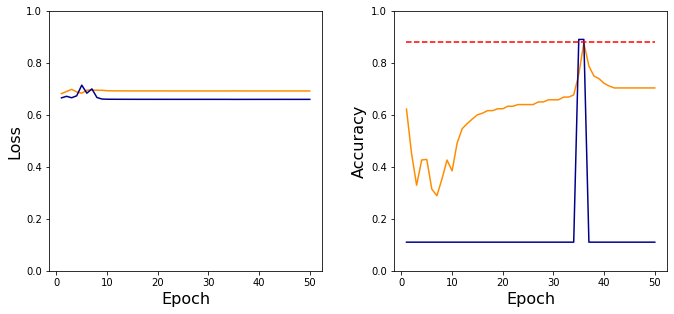

In [0]:
plot_metrics(my_cnn_history.history)

In [0]:
# get predictions on test set
test_pred = my_cnn.predict(test_frame_gen,
    verbose = 1,
    max_queue_size = 50)

25/25 [==============================] - 66s 3s/step


In [0]:
# evaluate model based on recall, precision, specificity and ROC AUC
get_metrics(test_pred)

TP = 1375, TN = 0, FP = 193, FN = 0

recall = 1.0, precision = 0.8769132653061225, specificity = 0.0


In [13]:
# run this to load saved model
custom_objects = {'recall_m':None, 'precision_m':None, 'f1_m':None}

my_cnn = load_model('models/my_cnn.001.h5', custom_objects=custom_objects)

## Transfer Learning with ImageNet Models

#### Xception

In [0]:
# import Xception model, apply transfer learning and fit on training data
from tensorflow.keras.applications.xception import Xception

xception = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(160, 160, 3)
)

xception_model = build_imagenet_model(xception)

for layer in xception_model.layers[:len(xception.layers)]:
    layer.trainable = False

xception_model.compile(
    loss='binary_crossentropy', optimizer=opt_001, 
    metrics=['binary_accuracy', recall_m, precision_m, f1_m])

mc = ModelCheckpoint('models/xception_model.001.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

xception_history = xception_model.fit( 
    train_generator, epochs=EPOCHS, steps_per_epoch=steps_train,
    verbose=1, shuffle=True, 
    validation_data=validation_generator, 
    validation_steps=steps_validation,
    class_weight=class_weight,
    max_queue_size=50,
    callbacks=[es, mc])

In [0]:
# to save training history, can write training dictionary as a pickle file
with open('histories/xception_history', 'wb') as filter:
        pickle.dump(xception_history.history, f)

# load saved training history
with open('histories/xception_history', 'rb') as f:
    xception_model_history = pickle.load(f)

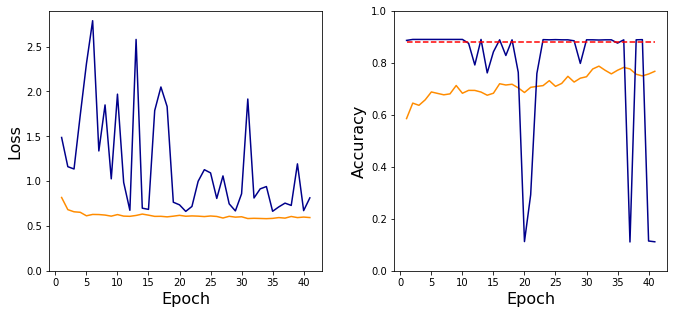

In [0]:
plot_metrics(xception_model_history)

In [0]:
xception_test_pred = xception_model.predict(
    test_frame_gen,
    verbose = 1,
    max_queue_size = 50)

25/25 [==============================] - 167s 7s/step


In [0]:
get_metrics(xception_test_pred)

TP = 359, TN = 150, FP = 43, FN = 1016

recall = 0.2610909090909091, precision = 0.8930348258706468, specificity = 0.7772020725388601


#### VGG16

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg16 = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(160, 160, 3)
)

vgg16_model = build_imagenet_model(vgg16)

for layer in vgg16_model.layers[:len(vgg16.layers)]:
    layer.trainable = False

vgg16_model.compile(
    loss='binary_crossentropy', 
    optimizer=opt_001, 
    metrics=['binary_accuracy', recall_m, precision_m, f1_m])

mc = ModelCheckpoint('vgg16_model.01.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

vgg16_history = vgg16_model.fit(
    train_generator, epochs=EPOCHS, steps_per_epoch=steps_train, verbose=1, 
    validation_data=validation_generator,
    validation_steps=steps_validation,
    class_weight=class_weight,
    max_queue_size=50,
    callbacks=[es, mc])

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
with open('histories/vgg16_history', 'wb') as file_pi:
    pickle.dump(vgg16_history.history, file_pi)

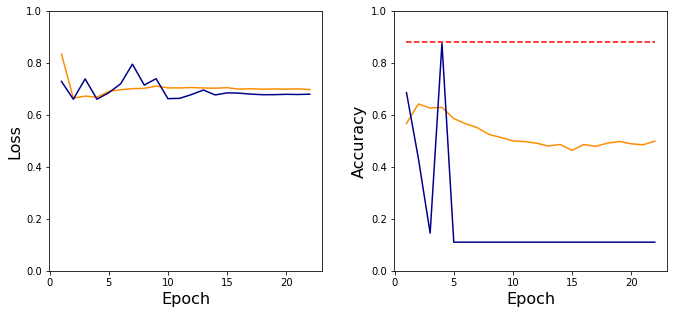

In [0]:
with open('histories/vgg16_history', 'rb') as f:
    vgg16_history = pickle.load(f)

plot_metrics(vgg16_history)

In [0]:
# custom function to obtain auc metric
# https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
def auc(y_true, y_pred):
    auc = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    return auc

In [0]:
# this was a model built on top of VGG16 trained on my local machine
vgg16_model = load_model('models/vgg16.h5', custom_objects={'auc':auc})
vgg16_test_pred = vgg16_model.predict(test_frame_gen,
    verbose = 1,
    max_queue_size = 50)

25/25 [==============================] - 409s 16s/step


In [0]:
get_metrics(vgg16_test_pred)

TP = 809, TN = 159, FP = 34, FN = 566

recall = 0.5883636363636363, precision = 0.9596678529062871, specificity = 0.8238341968911918


#### InceptionV3

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(160, 160, 3)
)

inception_model = build_imagenet_model(inception)

for layer in inception_model.layers[:len(inception.layers)]:
    layer.trainable = False

inception_model.compile(
    loss='binary_crossentropy', optimizer=opt_01,
    metrics=['binary_accuracy', recall_m, precision_m, f1_m])

mc = ModelCheckpoint('inception_model.01.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

inception_history = inception_model.fit(
    train_generator, epochs=EPOCHS, steps_per_epoch=steps_train, verbose=1, 
    validation_data=validation_generator,
    validation_steps=steps_validation,
    class_weight=class_weight,
    max_queue_size=50,
    callbacks=[es, mc])

87916544/87910968 [==============================] - 3s 0us/step


In [0]:
with open('histories/inception_history', 'wb') as file_pi:
    pickle.dump(inception_history.history, file_pi)

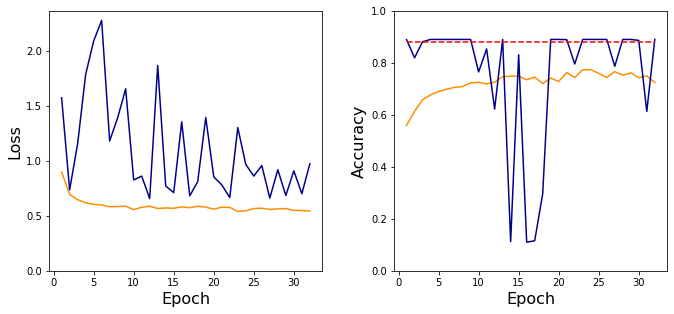

In [19]:
with open('histories/inception_history', 'rb') as f:
    inception_history = pickle.load(f)

plot_metrics(inception_history)

In [0]:
inception_test_pred = inception_model.predict(
    test_frame_gen,
    verbose = 1,
    max_queue_size = 50)

25/25 [==============================] - 78s 3s/step


In [0]:
get_metrics(inception_test_pred)

TP = 947, TN = 66, FP = 127, FN = 428

recall = 0.6887272727272727, precision = 0.8817504655493482, specificity = 0.34196891191709844


#### ResNet50V2

In [0]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

resnet50v2 = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(160, 160, 3)
)

resnet50v2_model = build_imagenet_model(resnet50v2)

for layer in resnet50v2_model.layers[:len(resnet50v2.layers)]:
    layer.trainable = False

resnet50v2_model.compile(
    loss='binary_crossentropy', optimizer=opt_01, 
    metrics=['binary_accuracy', recall_m, precision_m, f1_m])

mc = ModelCheckpoint('models/resnet50v2_model.01.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

resnet50v2_history = resnet50v2_model.fit(
    train_generator, epochs=EPOCHS, steps_per_epoch=steps_train, verbose=1, 
    validation_data=validation_generator,
    validation_steps=steps_validation,
    class_weight=class_weight,
    max_queue_size=50,
    callbacks=[es, mc])

94674944/94668760 [==============================] - 3s 0us/step


In [0]:
with open('histories/resnet50v2_history', 'wb') as file_pi:
    pickle.dump(resnet50v2_history.history, file_pi)

In [0]:
resnet50v2_test_pred = resnet50v2_model.predict(
    test_frame_gen,
    verbose = 1,
    max_queue_size = 50)

25/25 [==============================] - 113s 5s/step


In [0]:
get_metrics(resnet50v2_test_pred)

TP = 1375, TN = 1, FP = 192, FN = 0

recall = 1.0, precision = 0.8774728781110402, specificity = 0.0051813471502590676


## Time Distributed CNN Passed to a RNN

Reading in raw images caches too much memory and drastically contributes to the time required for training (I was encountering > 14 hours for just a single epoch). To optimize the speed of reading in files, I loaded my data as h5 files in batches of 32 videos.

In [0]:
# function to create batches of h5 files
def h5_batches(metadata, subset, batch_n, batch_size=32):
    index_min = batch_n*batch_size
    # Adjust for smaller final batch
    index_max = min(index_min + batch_size, len(metadata))
    df = metadata[index_min:index_max]

    with h5py.File(f'{subset}_h5/{batch_n}.h5', "w") as f:
        X_train = f.create_dataset("X_train", (len(df),30,160,160,3), dtype='float32') # , maxshape=(None,30,160,160,3)
        y_train = f.create_dataset("y_train",(len(df),),dtype='u1')

        videos = []
        count = 0
        for dir in df['filename']:
            vid_path = subset + '/' + dir

            frames=[]
            # read frames in order
            for file in sorted(os.scandir(vid_path), key=lambda vid: vid.name):
                frame = imageio.imread(vid_path + '/' + file.name)
                frames.append(frame)

            # pad videos with zero matrices if less than 30 frames
            if len(frames) < 30:
                n_pads = 30 - len(frames)
                zero_pads = np.zeros((n_pads, 160, 160, 3))
                frames = np.concatenate((frames, zero_pads))

            videos.append(frames)
            print(f'batch number={batch_n}, vid_number={count}, vid_id={dir}\r')
            count += 1

        videos = np.array(videos)
        x = videos.astype('float32')
        x /= 255

        X_train[:,] = x

        y_train[:,] = np.array(df['label'])
        f.close()

In [0]:
# CODE TAKES EXTREMELY LONG
# generate batches of h5 files, each with 32 videos of 30 frames each
for i in range(0, int(np.ceil(len(train)/32)) + 1):
    h5_batches(train, 'train', batch_n=i)

for i in range(0, int(np.ceil(len(validation)/32)) + 1):
    h5_batches(validation, 'validation', batch_n=i)

for i in range(0, int(np.ceil(len(test)/32)) + 1):
    h5_batches(test, 'test', batch_n=i)

In [0]:
# functions to create custom batch generators for videos
def load_frames(batch_n, subset):
    with h5py.File(f'{subset}_h5/{batch_n}.h5', "r") as f:
        x = f['X_train'][:]
        y = f['y_train'][:]
        f.close()
    
    return (x, y)

def vid_batch_generator(batch_n, steps, subset):
    batch_n = 1
    while True: 
        yield load_frames(batch_n-1, subset)
        if batch_n < steps:
            batch_n+=1
        else:
            batch_n=1

In [0]:
# function build NN for transfer learning using multiple frames per video
# TimeDistributed ImageNet Model passed to recurrent NN
def build_TD_imagenet_model(pretrained_model):
    model = Sequential([
        TimeDistributed(pretrained_model, input_shape=(30, 160, 160, 3)),
        Dropout(0.5),
        BatchNormalization(),
        TimeDistributed(Flatten()),
        
        # Masking layer to ignore padded zeroes
        Masking(mask_value=0., input_shape=(30, 160, 160, 3)),

        LSTM(64, activation='relu', return_sequences=True),
        Dropout(0.25),
        BatchNormalization(),
        LSTM(256, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),
        Dense(512, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])
    
    return model

In [0]:
# Hyperparameters and generators for video classification
EPOCHS=20
BATCH_SIZE = 32

train_vid_generator = vid_batch_generator(
    BATCH_SIZE, steps_train, subset='train')

validation_vid_generator = vid_batch_generator(
    BATCH_SIZE, steps_validation, subset='validation')

test_vid_generator = vid_batch_generator(
    BATCH_SIZE, steps_validation, subset='test')

#### Xception

In [0]:
from tensorflow.keras.applications.xception import Xception

xception = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(160, 160, 3)
)

xception_TD_model = build_TD_imagenet_model(xception)

for layer in xception_TD_model.layers[:1]:
    layer.trainable = False

xception_TD_model.compile(
    loss='binary_crossentropy', optimizer=opt_01, 
    metrics=['binary_accuracy', recall_m, precision_m, f1_m])

mc = ModelCheckpoint('models/xception_TD_model.01.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

xception_TD_history = xception_TD_model.fit(
    train_vid_generator, epochs=EPOCHS, 
    steps_per_epoch=steps_train, 
    validation_data=validation_vid_generator,
    validation_steps=steps_validation,
    class_weight=class_weight,
    max_queue_size=50,
    callbacks=[es, mc],
    verbose=1)

83689472/83683744 [==============================] - 1s 0us/step


#### VGG19

In [0]:
from tensorflow.keras.applications.vgg19 import VGG19

vgg19 = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(160, 160, 3)
)

vgg19_TD_model = build_TD_imagenet_model(vgg19)

for layer in vgg19_TD_model.layers[:1]:
    layer.trainable = False

80142336/80134624 [==============================] - 1s 0us/step


In [0]:
vgg19_TD_model.compile(
    loss='binary_crossentropy', optimizer=opt_01, 
    metrics=['binary_accuracy', recall_m, precision_m, f1_m])

mc = ModelCheckpoint('models/vgg19_TD_model.01.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [0]:
vgg19_TD_history = vgg19_TD_model.fit(
    train_vid_generator, epochs=20, 
    steps_per_epoch=steps_train, 
    validation_data=validation_vid_generator,
    validation_steps=steps_validation,
    class_weight=class_weight,
    max_queue_size=50,
    callbacks=[es, mc],
    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 175 steps, validate for 44 steps
Epoch 1/20
  1/175 [..............................] - ETA: 1:06:01WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: 


ResourceExhaustedError: ignored

#### VGG16

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg16 = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(160, 160, 3)
)

vgg16_TD_model = build_TD_imagenet_model(vgg16)

for layer in vgg16_TD_model.layers[:1]:
    layer.trainable = False

58892288/58889256 [==============================] - 5s 0us/step


In [0]:
vgg16_TD_model.compile(
    loss='binary_crossentropy', optimizer=opt_01, 
    metrics=['binary_accuracy', recall_m, precision_m, f1_m])

mc = ModelCheckpoint('models/vgg16_TD_model.01.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [0]:
vgg16_TD_history = vgg16_TD_model.fit(
    train_vid_generator, epochs=20, 
    steps_per_epoch=steps_train, 
    validation_data=validation_vid_generator,
    validation_steps=steps_validation,
    class_weight=class_weight,
    max_queue_size=50,
    callbacks=[es, mc],
    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 175 steps, validate for 44 steps
Epoch 1/20
174/175 [============================>.] - ETA: 7s - loss: 0.8495 - binary_accuracy: 0.5860 - recall_m: 0.5878 - precision_m: 0.8934 - f1_m: 0.6885 
Epoch 00001: val_loss improved from inf to 0.74634, saving model to models/vgg16_TD_model.01.h5
175/175 [==============================] - 1670s 10s/step - loss: 0.8547 - binary_accuracy: 0.5853 - recall_m: 0.5865 - precision_m: 0.8912 - f1_m: 0.6870 - val_loss: 0.7463 - val_binary_accuracy: 0.1127 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/20
174/175 [============================>.] - ETA: 7s - loss: 0.7471 - binary_accuracy: 0.5616 - recall_m: 0.5555 - precision_m: 0.8833 - f1_m: 0.6515 
Epoch 00002: val_loss improved from 0.74634 to 0.67194, saving model to models/vgg16_TD_model.01.h5
175/175 [==============================] - 1680s 10s/step - loss: 0.7499 - binary_accuracy: 0.5610 - recall

## Archived

In [0]:
# modified from https://mc.ai/train-keras-model-with-large-dataset-batch-training/
def load_frame(df, batch_n, batch_size, subset):
    if batch_n > 0:
        batch = pd.read_csv(df, skiprows=batch_n*batch_size+1, nrows=batch_size, names=['filename', 'label'])
    else:
        batch = pd.read_csv(df, skiprows=batch_n*batch_size, nrows=batch_size)
    
    frames = []
    for dir in batch['filename']:
        try:
            frame_path = subset + '/' + dir + '/' + os.listdir(subset + '/' + dir)[14]
        #if 15th frame does not exist, use first frame
        except IndexError:
            frame_path = subset + '/' + dir + '/' + os.listdir(subset + '/' + dir)[0]

        frame = imageio.imread(frame_path)

        frames.append(frame)
    
    frames = np.array(frames)
    x = frames.astype('float32')
    x /= 255
    
    y = np.array(batch['label'])
    #print(y)
    
    #print(f'{batch_n} passed')
    return (x, y)

def batch_generator(df, batch_size, steps, subset):
    batch_n = 1
    while True: 
        yield load_frame(df, batch_n-1, batch_size, subset)
        if batch_n < steps:
            batch_n+=1
        else:
            batch_n=1

In [0]:
def load_frames(df, batch_n, batch_size, subset):
    if batch_n > 0:
        df = pd.read_csv(df, skiprows=batch_n*batch_size+1, nrows=batch_size, names=['filename', 'label'])
    else:
        df = pd.read_csv(df, skiprows=batch_n*batch_size, nrows=batch_size)
    
    videos = []
    for dir in df['filename']:
        vid_path = subset + '/' + dir

        frames=[]
        # read frames in order
        for file in sorted(os.scandir(vid_path), key=lambda f: f.name):
            #print(vid_path + '/' + file.name)
            frame = imageio.imread(vid_path + '/' + file.name)
            frames.append(frame)

        # pad videos with zero matrices if less than 30 frames
        if len(frames) < 30:
            n_pads = 30 - len(frames)
            zero_pads = np.zeros((n_pads, 160, 160, 3))
            frames = np.concatenate((frames, zero_pads))
        
        videos.append(frames)
    
    videos = np.array(videos)
    x = videos.astype('float32')
    x /= 255
    
    y = np.array(df['label'])
    #print(y)
    
    #print(f'{batch_n} passed')
    return (x, y)

def vid_batch_generator(df, batch_size, steps, subset):
    batch_n = 1
    while True: 
        yield load_frames(df, batch_n-1, batch_size, subset)
        if batch_n < steps:
            batch_n+=1
        else:
            batch_n=1